In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import boto3

In [6]:
my_region = boto3.session.Session().region_name
print(f"Region: {my_region}")

s3 = boto3.client('s3', aws_access_key_id = aws_access_key_id, aws_secret_access_key = aws_secret_access_key)

Region: eu-west-2


In [7]:
bucket_name = 'bucket-medical'
csv_key = 'insurance.csv'

obj = s3.get_object(Bucket = bucket_name, Key = csv_key)
df = pd.read_csv(obj['Body'])

## Perform exploratory data analysis

In [8]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


<Axes: >

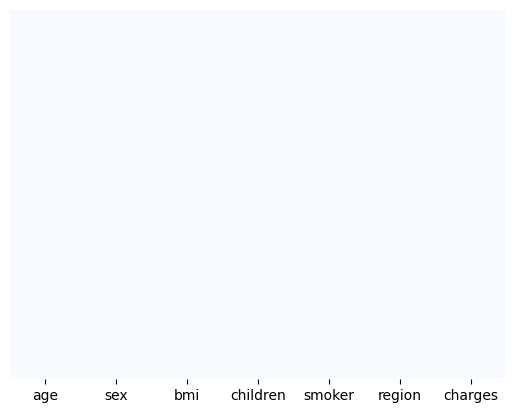

In [9]:
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap = "Blues")

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [11]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [12]:
df['sex'].unique()

array(['female', 'male'], dtype=object)

In [13]:
df['sex']= df['sex'].apply(lambda x: 0 if x == 'female' else 1)

In [14]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,yes,southwest,16884.92400
1,18,1,33.770,1,no,southeast,1725.55230
2,28,1,33.000,3,no,southeast,4449.46200
3,33,1,22.705,0,no,northwest,21984.47061
4,32,1,28.880,0,no,northwest,3866.85520


In [15]:
df['smoker'] = df['smoker'].apply(lambda x: 0 if x == 'no' else 1)

In [16]:
region_dummies = pd.get_dummies(df['region'], drop_first = True)

In [17]:
df = pd.concat([df, region_dummies], axis = 1)

In [18]:
df.head()

,age,sex,bmi,children,smoker,region,charges,northwest,southeast,southwest
0,19,0,27.900,0,1,southwest,16884.92400,False,False,True
1,18,1,33.770,1,0,southeast,1725.55230,False,True,False
2,28,1,33.000,3,0,southeast,4449.46200,False,True,False
3,33,1,22.705,0,0,northwest,21984.47061,True,False,False
4,32,1,28.880,0,0,northwest,3866.85520,True,False,False


In [19]:
df = df.drop(['region'], axis = 1)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        1338 non-null   int64  
 1   sex        1338 non-null   int64  
 2   bmi        1338 non-null   float64
 3   children   1338 non-null   int64  
 4   smoker     1338 non-null   int64  
 5   charges    1338 non-null   float64
 6   northwest  1338 non-null   bool   
 7   southeast  1338 non-null   bool   
 8   southwest  1338 non-null   bool   
dtypes: bool(3), float64(2), int64(4)
memory usage: 66.8 KB


In [21]:
dummy_names = ['northwest', 'southeast', 'southwest']

for name in dummy_names:
    df[name] = df[name].apply(lambda x: 0 if x == False else 1)

In [22]:
print(np.round(df[['age', 'bmi', 'charges']].mean(),2))
print(np.round(df[['age', 'bmi', 'charges']].std(),2))

age           39.21
bmi           30.66
charges    13270.42
dtype: float64
age           14.05
bmi            6.10
charges    12110.01
dtype: float64


## Data visualisation

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'sex'}>],
       [<Axes: title={'center': 'bmi'}>,
        <Axes: title={'center': 'children'}>],
       [<Axes: title={'center': 'smoker'}>,
        <Axes: title={'center': 'charges'}>]], dtype=object)

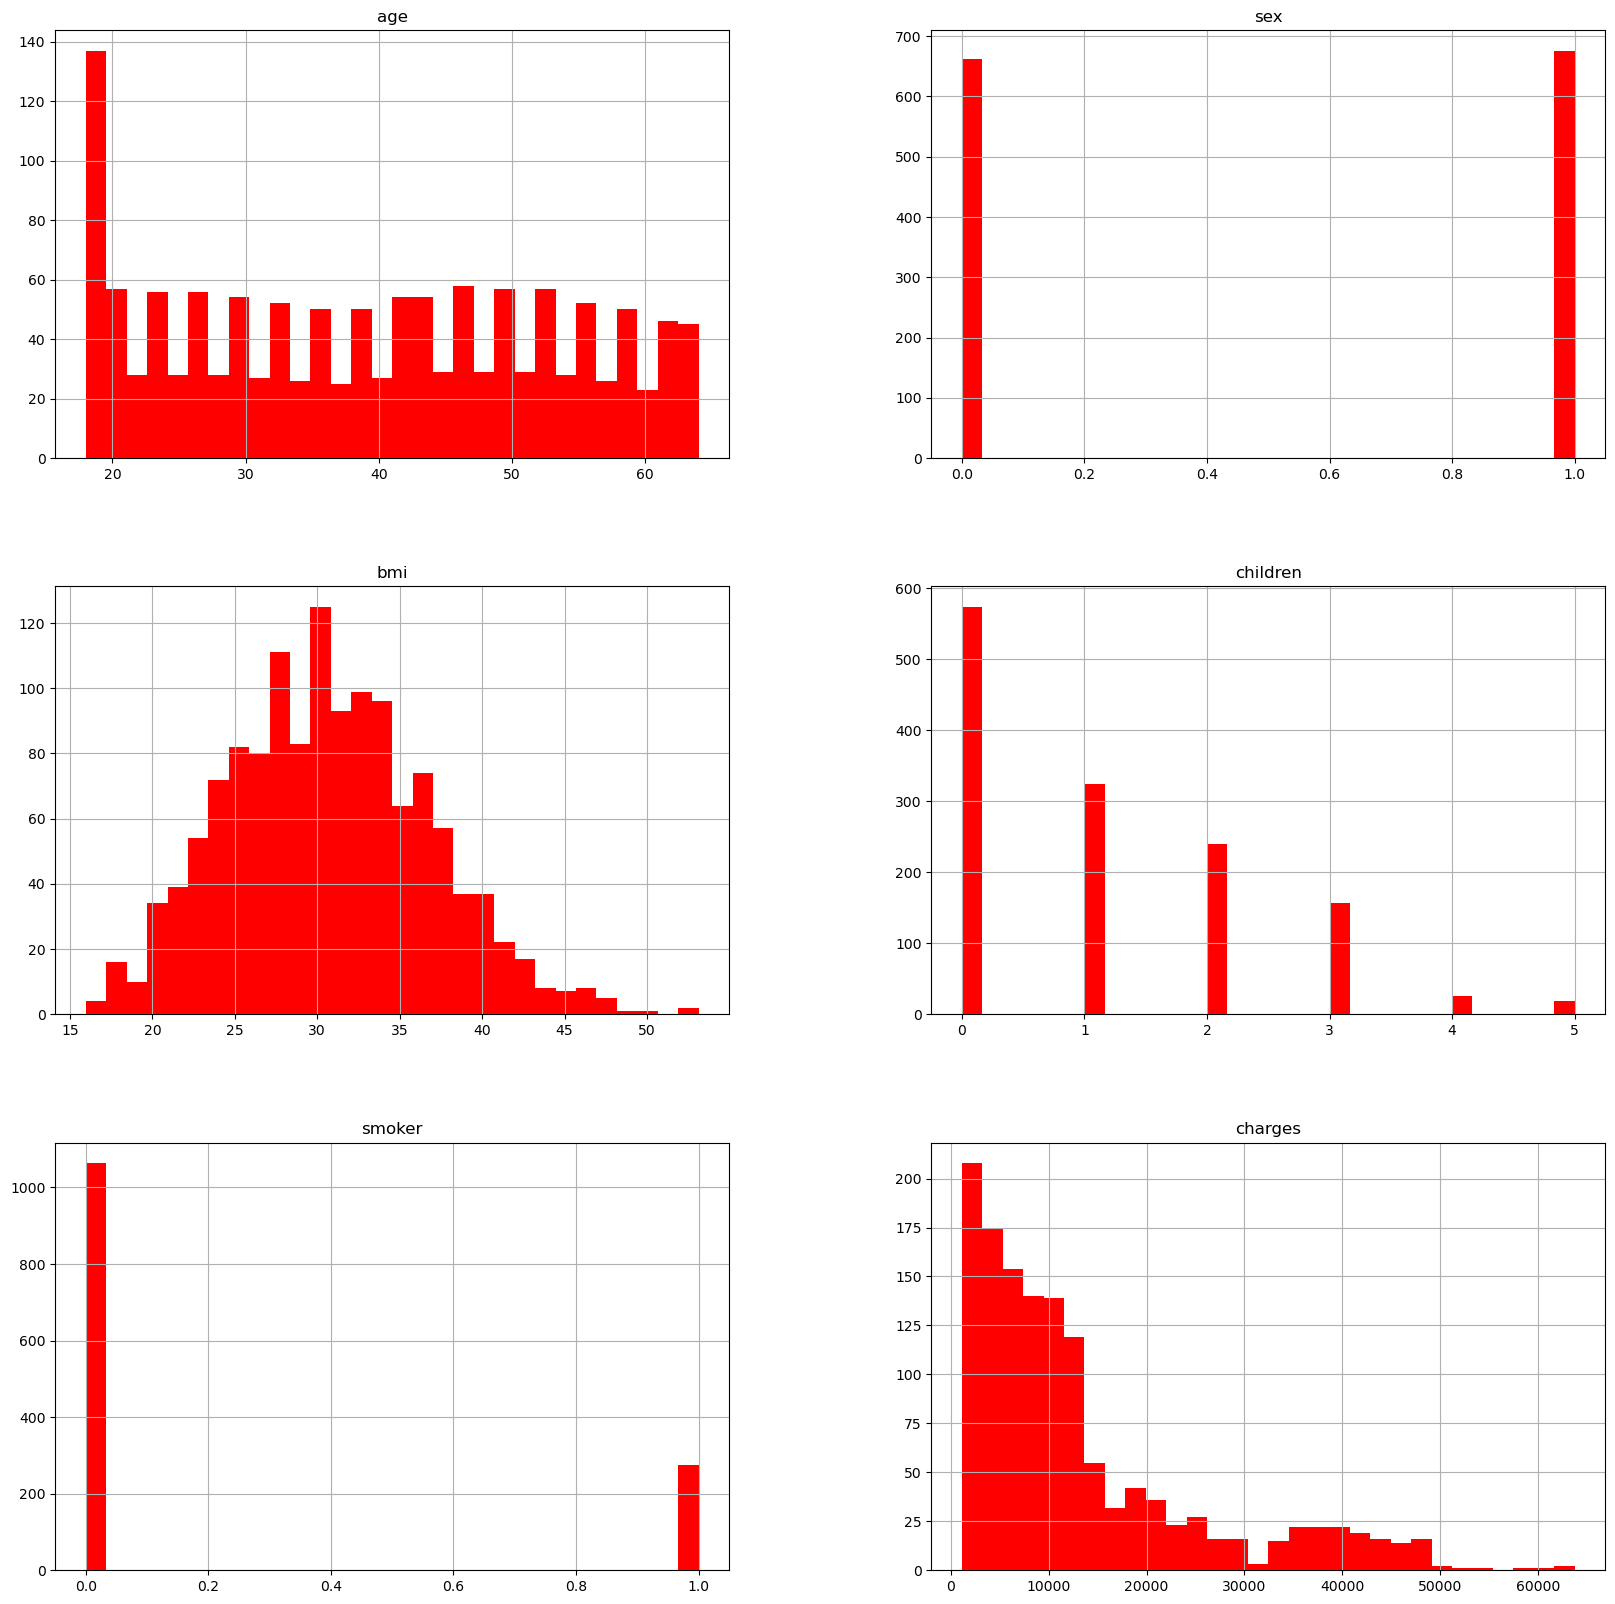

In [23]:
df[['age', 'sex', 'bmi', 'children', 'smoker', 'charges']].hist(bins = 30, figsize = (20, 20), color = 'r')

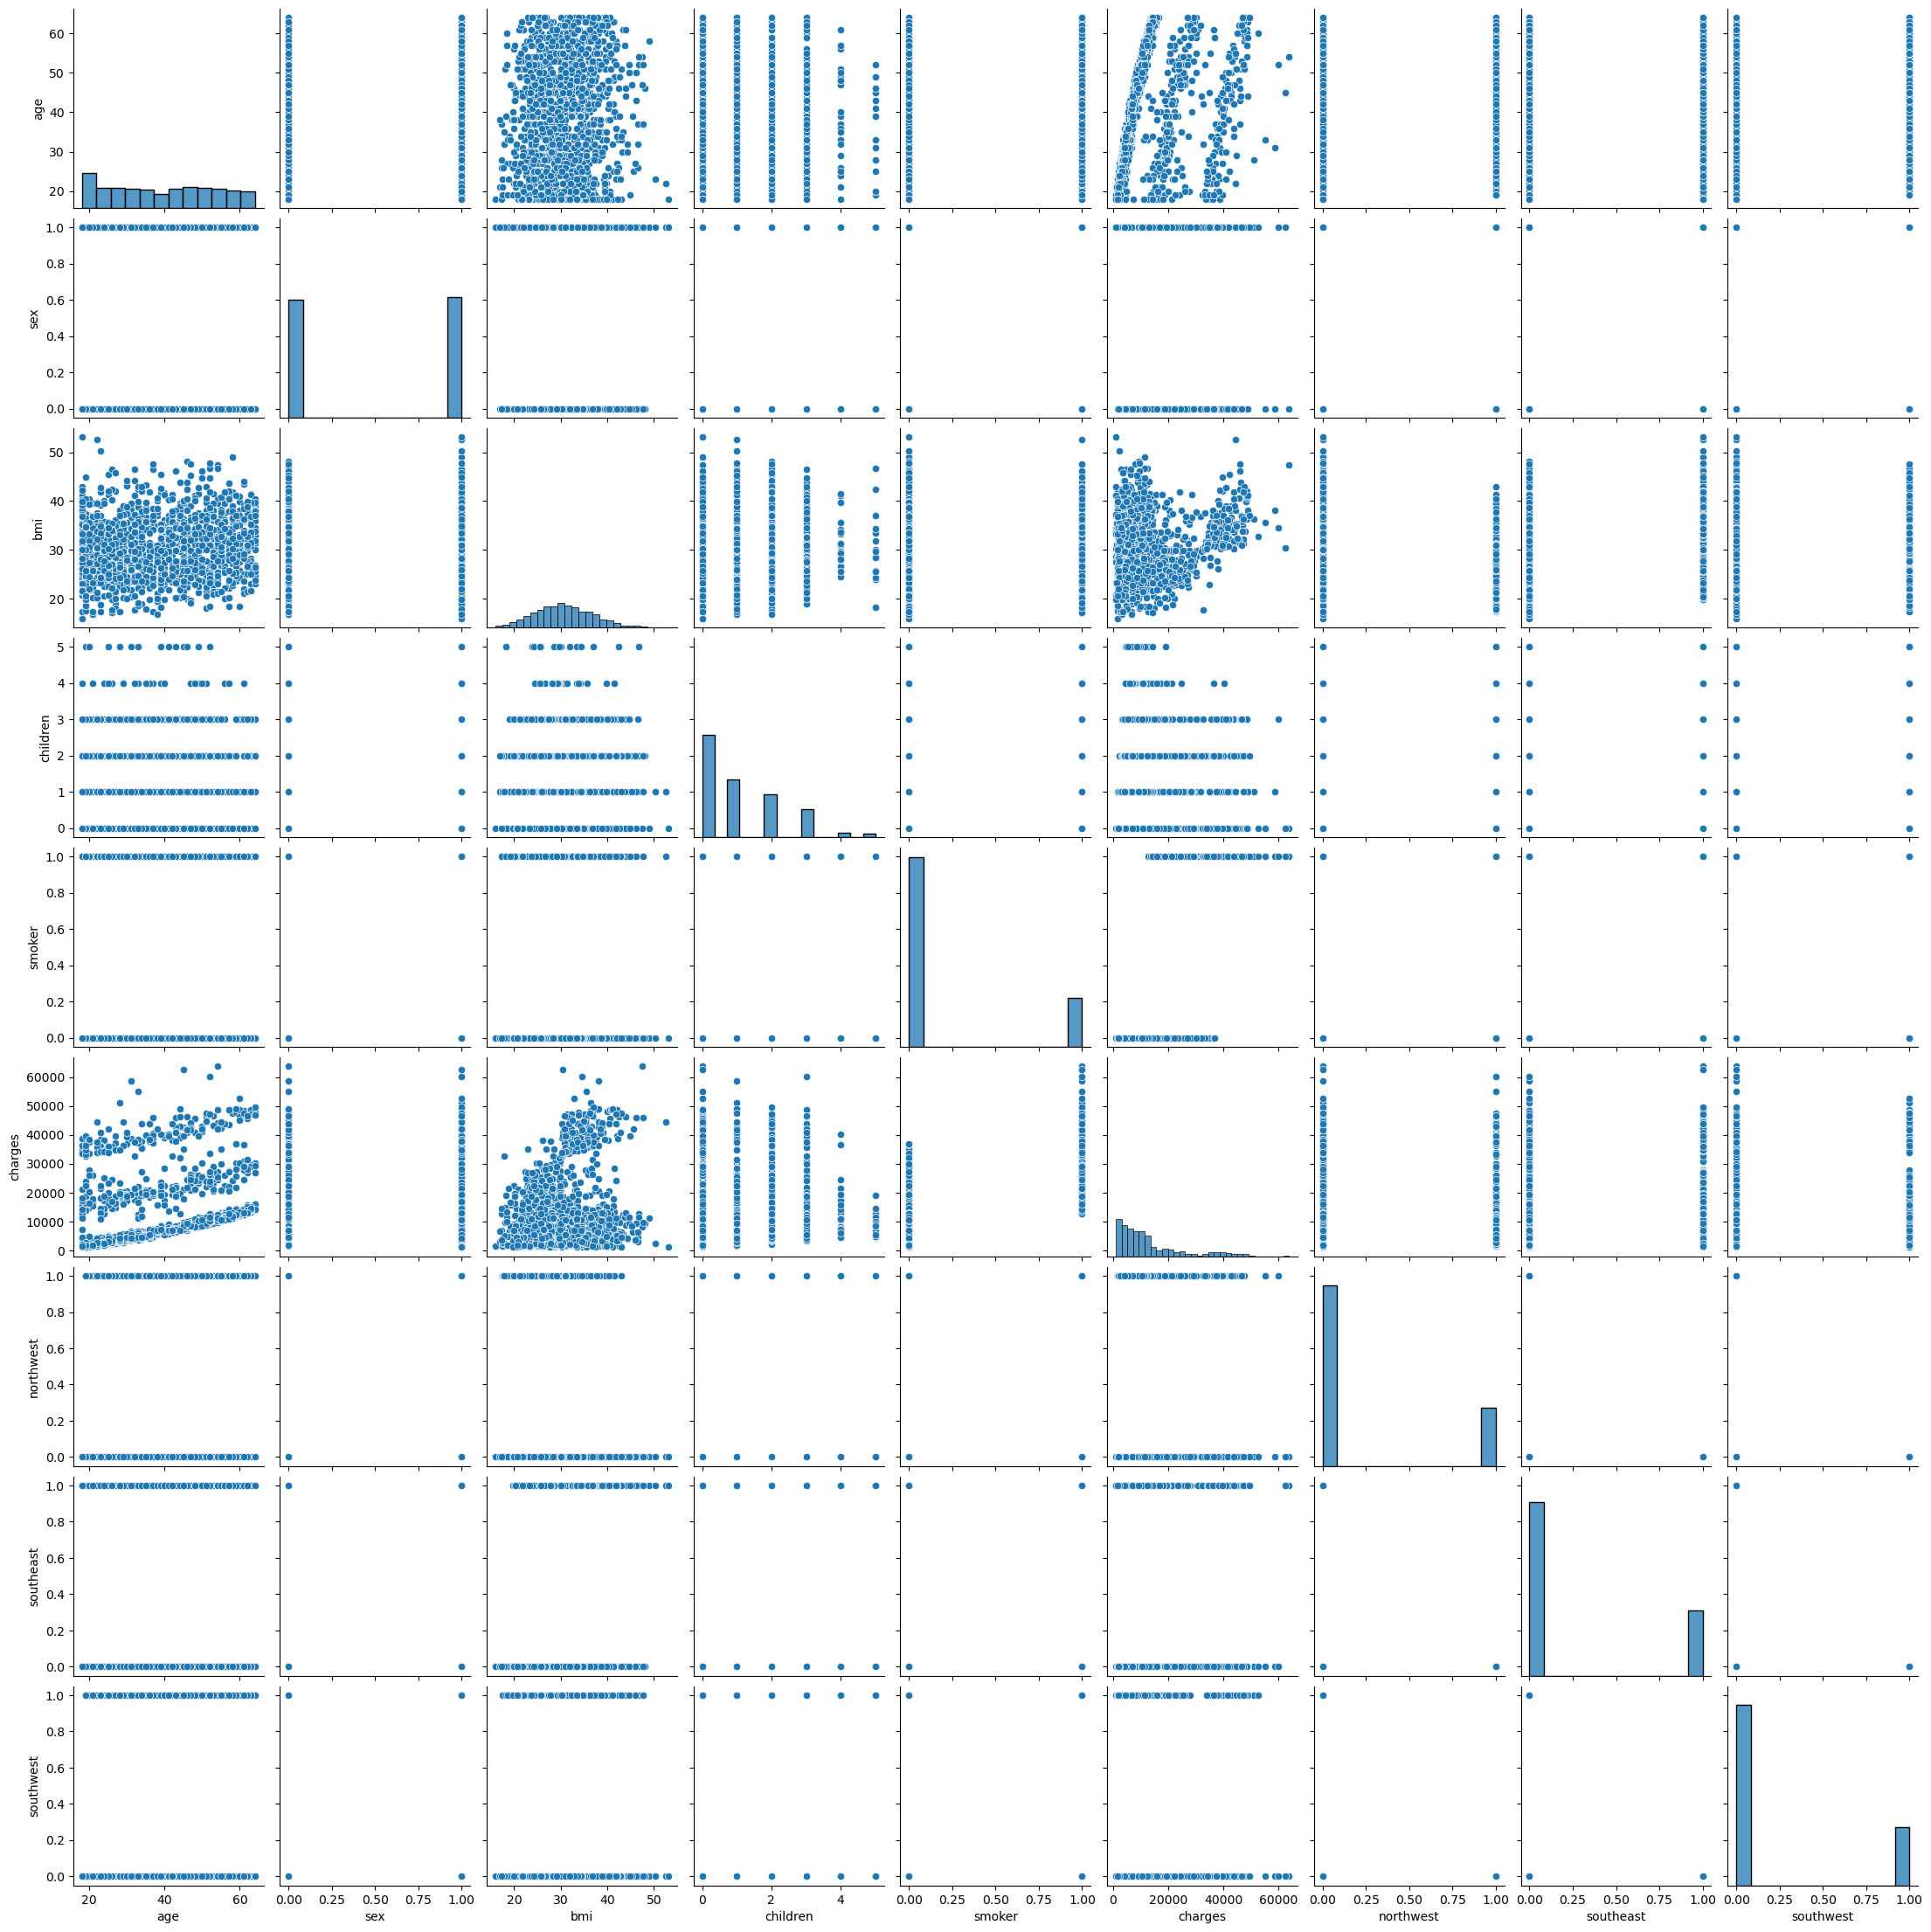

In [24]:
sns.pairplot(df)

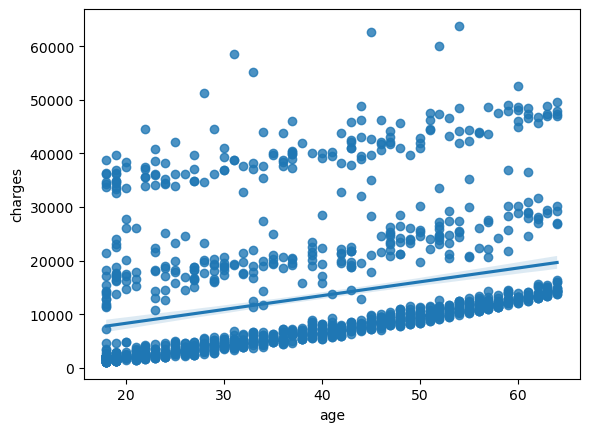

In [25]:
sns.regplot(x = 'age', y = 'charges', data = df)
plt.show()

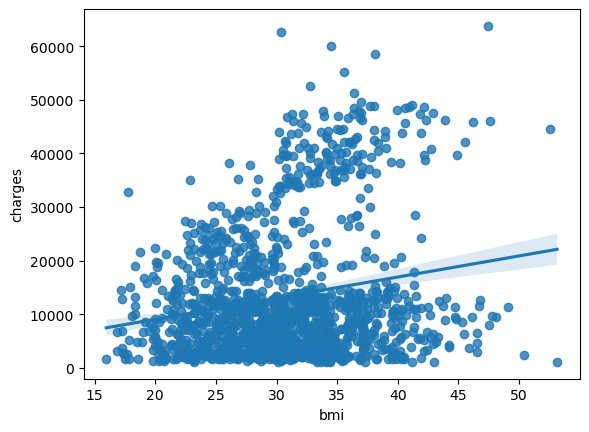

In [26]:
sns.regplot(x = 'bmi', y = 'charges',  data = df)
plt.show()

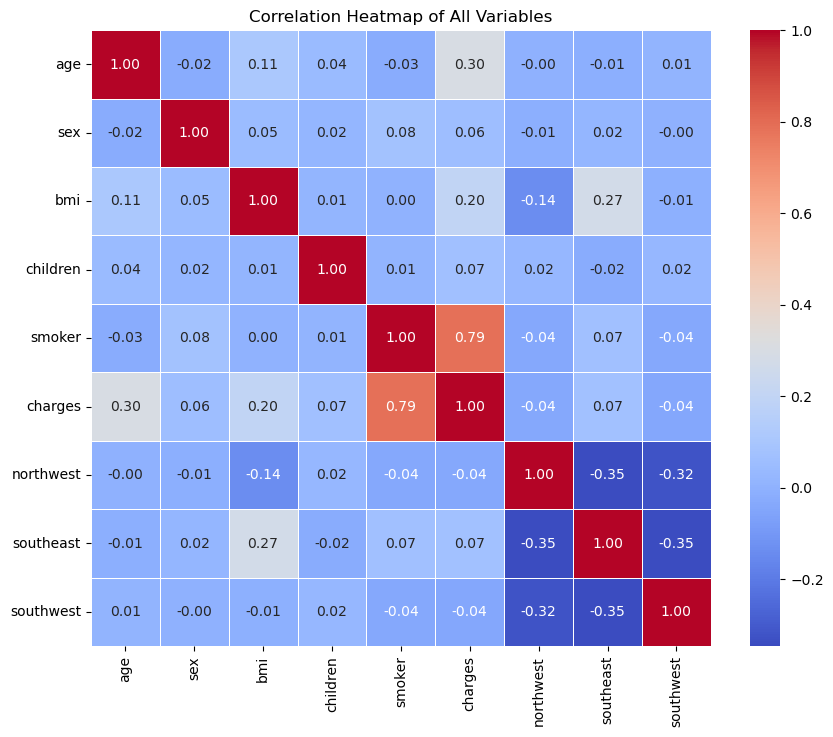

In [27]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of All Variables')
plt.show()

## Training and testing datasets

In [28]:
X = df.drop(columns = ['charges'])
y  =df['charges']

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
print(X.shape, y.shape)

(1338, 8) (1338,)


In [31]:
X = np.array(X).astype('float32')
y = np.array(y).astype('float32')

y = y.reshape(-1, 1)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

In [33]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.fit_transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.fit_transform(y_test)

In [34]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1070, 8) (268, 8) (1070, 1) (268, 1)


## SKLearn linear regression

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score

regression_model_sklearn = LinearRegression()
regression_model_sklearn.fit(X_train, y_train)

LinearRegression()

In [36]:
regression_model_sklearn_accuracy = regression_model_sklearn.score(X_test, y_test)
print(f"sklearn accuracy score: {regression_model_sklearn_accuracy}")

sklearn accuracy score: 0.7996150337305619


In [37]:
y_predict = regression_model_sklearn.predict(X_test)

In [38]:
y_predict_orig = scaler_y.inverse_transform(y_predict)
y_test_orig = scaler_y.inverse_transform(y_test)

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

RMSE = float(format(np.sqrt(mean_squared_error(y_test_orig, y_predict_orig)), '.3f'))
MSE = mean_squared_error(y_test_orig, y_predict_orig)
MAE = mean_absolute_error(y_test_orig, y_predict_orig)

In [40]:
print(f"RMSE: {RMSE} | MSE: {MSE} | MAE: {MAE}")

RMSE: 5535.158 | MSE: 30637972.0 | MAE: 3957.0625


## LINEAR REGRESSION USING SAGEMAKER

In [41]:
import sagemaker
import boto3
from sagemaker import Session

sagemaker_session = sagemaker.Session()
prefix = 'medical-insurance'

role = sagemaker.get_execution_role()
print(role)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
arn:aws:iam::125544413952:role/service-role/AmazonSageMaker-ExecutionRole-20231219T123112


In [42]:
import io 
import sagemaker.amazon.common as smac

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, X_train, y_train.reshape(-1))

buf.seek(0)

0

In [43]:
import os

key = 'medical-train-data'

boto3.resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)

s3_training_data = 's3://{}/{}/train/{}'.format(bucket_name, prefix, key)
print(f"Uploaded training data to: {s3_training_data}")

Uploaded training data to: s3://bucket-medical/medical-insurance/train/medical-train-data


In [44]:
output_location = 's3://{}/{}/output'.format(bucket_name, prefix)
print(f"Training artifacts will be uploaded to: {output_location}")

Training artifacts will be uploaded to: s3://bucket-medical/medical-insurance/output


In [45]:
from sagemaker import image_uris

container = image_uris.retrieve('linear-learner', boto3.Session().region_name)

In [46]:
linear = sagemaker.estimator.Estimator(image_uri = container,
                                      role = role,
                                      instance_count = 1,
                                      instance_type = 'ml.m5.large',
                                      output_path = output_location,
                                      sagemaker_session = sagemaker_session,
                                      use_spot_instances = True,
                                      max_run = 300,
                                      max_wait = 600)

linear.set_hyperparameters(feature_dim = 8,
                          predictor_type = 'regressor',
                          mini_batch_size = 50,
                          epochs = 100,
                          num_models = 32,
                          loss = 'absolute_loss')

linear.fit({'train': s3_training_data})

INFO:sagemaker:Creating training-job with name: linear-learner-2023-12-19-15-25-40-742


2023-12-19 15:25:40 Starting - Starting the training job...
2023-12-19 15:25:56 Starting - Preparing the instances for training.........
2023-12-19 15:27:18 Downloading - Downloading input data...
2023-12-19 15:27:59 Downloading - Downloading the training image......
2023-12-19 15:29:10 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/19/2023 15:29:14 INFO 140162028652352] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'lo

## Model deployment

In [47]:
linear_regressor = linear.deploy(initial_instance_count = 1,
                                instance_type = 'ml.m4.xlarge')

INFO:sagemaker:Creating model with name: linear-learner-2023-12-19-15-30-24-134
INFO:sagemaker:Creating endpoint-config with name linear-learner-2023-12-19-15-30-24-134
INFO:sagemaker:Creating endpoint with name linear-learner-2023-12-19-15-30-24-134


-------!

In [48]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

linear_regressor.content_type = 'text/csv'
linear_regressor.serializer = CSVSerializer()
linear_regressor.deserializer = JSONDeserializer()

In [49]:
result = linear_regressor.predict(X_test)
print(result)

{'predictions': [{'score': -0.2742958664894104}, {'score': -0.6806549429893494}, {'score': 1.5920610427856445}, {'score': -0.6909171938896179}, {'score': -0.20250986516475677}, {'score': -0.2711985111236572}, {'score': -0.7895649671554565}, {'score': -0.7474929094314575}, {'score': -1.0143905878067017}, {'score': -0.35156404972076416}, {'score': -0.6151016354560852}, {'score': -0.22501994669437408}, {'score': -0.2744738459587097}, {'score': 1.6297528743743896}, {'score': -0.16187483072280884}, {'score': 1.8324439525604248}, {'score': -0.22786013782024384}, {'score': -1.0315921306610107}, {'score': 1.9075294733047485}, {'score': 1.956221342086792}, {'score': 2.1231846809387207}, {'score': 2.2424979209899902}, {'score': -0.9324535727500916}, {'score': -0.47495609521865845}, {'score': -0.9823188781738281}, {'score': -0.32699474692344666}, {'score': 0.0010265575256198645}, {'score': -0.6885684728622437}, {'score': -0.18198992311954498}, {'score': -1.0952203273773193}, {'score': -0.41278114

In [50]:
predictions = np.array([r['score'] for r in result['predictions']])

In [51]:
predictions.shape

(268,)

In [52]:
y_predict_orig = scaler_y.inverse_transform(predictions.reshape(-1, 1))
y_test_orig = scaler_y.inverse_transform(y_test)

In [53]:
RMSE = float(format(np.sqrt(mean_squared_error(y_test_orig, y_predict_orig)), '.3f'))
MSE = mean_squared_error(y_test_orig, y_predict_orig)
MAE = mean_absolute_error(y_test_orig, y_predict_orig)

In [54]:
print(f"RMSE: {RMSE} | MSE: {MSE} | MAE: {MAE}")

RMSE: 6114.29 | MSE: 37384545.34116402 | MAE: 3056.7869426275383


In [55]:
linear_regressor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: linear-learner-2023-12-19-15-30-24-134
INFO:sagemaker:Deleting endpoint with name: linear-learner-2023-12-19-15-30-24-134


## NEURAL NETWORK

In [56]:
# !pip install tensorflow

In [57]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

2023-12-19 15:34:27.015840: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-19 15:34:27.015898: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-19 15:34:27.017418: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-19 15:34:27.026428: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-19 15:34:28.341360: W tensorflow/compiler/tf2

In [58]:
# optimizer = Adam()
ANN_model = keras.Sequential()
ANN_model.add(Dense(50, input_dim = 8))
ANN_model.add(Activation('relu'))
ANN_model.add(Dense(150))
ANN_model.add(Activation('relu'))
ANN_model.add(Dropout(0.5))
ANN_model.add(Dense(150))
ANN_model.add(Activation('relu'))
ANN_model.add(Dropout(0.5))
ANN_model.add(Dense(50))
ANN_model.add(Activation('linear'))
ANN_model.add(Dense(1))
ANN_model.compile(loss = 'mse', optimizer = 'adam')
ANN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                450       
                                                                 
 activation (Activation)     (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 150)               7650      
                                                                 
 activation_1 (Activation)   (None, 150)               0         
                                                                 
 dropout (Dropout)           (None, 150)               0         
                                                                 
 dense_2 (Dense)             (None, 150)               22650     
                                                                 
 activation_2 (Activation)   (None, 150)               0

2023-12-19 15:34:29.391073: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [61]:
ANN_model.compile(optimizer = 'Adam', loss = 'mean_squared_error')

epochs_hist = ANN_model.fit(X_train, y_train, epochs = 100, batch_size = 20, validation_split = 0.2)

Epoch 1/100
43/43 [==============================] - 1s 6ms/step - loss: 0.1237 - val_loss: 0.1966
Epoch 2/100
43/43 [==============================] - 0s 3ms/step - loss: 0.1400 - val_loss: 0.2015
Epoch 3/100
43/43 [==============================] - 0s 3ms/step - loss: 0.1282 - val_loss: 0.2023
Epoch 4/100
43/43 [==============================] - 0s 3ms/step - loss: 0.1191 - val_loss: 0.2058
Epoch 5/100
43/43 [==============================] - 0s 3ms/step - loss: 0.1203 - val_loss: 0.2077
Epoch 6/100
43/43 [==============================] - 0s 3ms/step - loss: 0.1329 - val_loss: 0.2049
Epoch 7/100
43/43 [==============================] - 0s 3ms/step - loss: 0.1289 - val_loss: 0.2137
Epoch 8/100
43/43 [==============================] - 0s 3ms/step - loss: 0.1389 - val_loss: 0.2108
Epoch 9/100
43/43 [==============================] - 0s 3ms/step - loss: 0.1368 - val_loss: 0.2072
Epoch 10/100
43/43 [==============================] - 0s 3ms/step - loss: 0.1276 - val_loss: 0.2104
Epoch 11/

In [62]:
result = ANN_model.evaluate(X_test, y_test)
accuracy_ANN = 1 - result
print("Accuracy : {}".format(accuracy_ANN))

9/9 [==============================] - 0s 2ms/step - loss: 0.1395
Accuracy : 0.8604864776134491


In [63]:
epochs_hist.history.keys()

dict_keys(['loss', 'val_loss'])

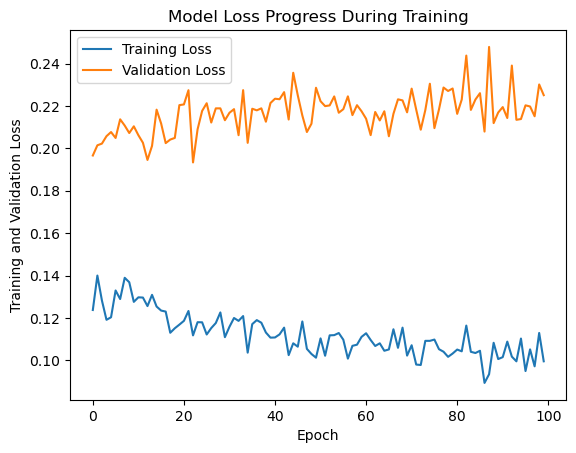

In [64]:
plt.plot(epochs_hist.history['loss'])
plt.plot(epochs_hist.history['val_loss'])
plt.title('Model Loss Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training and Validation Loss')
plt.legend(['Training Loss', 'Validation Loss'])

9/9 [==============================] - 0s 1ms/step


Text(0, 0.5, 'True Values')

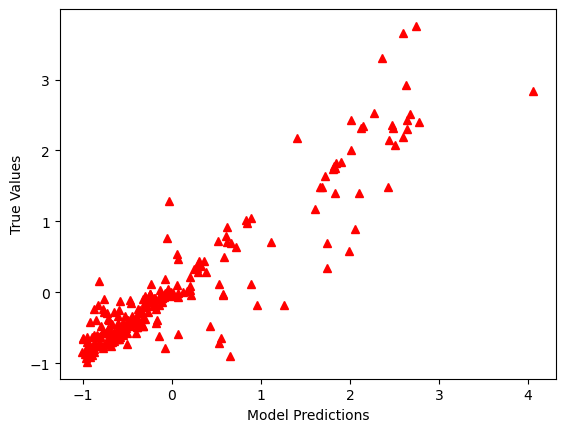

In [65]:
y_predict = ANN_model.predict(X_test)
plt.plot(y_test, y_predict, "^", color = 'r')
plt.xlabel('Model Predictions')
plt.ylabel('True Values')

In [66]:
y_predict_orig = scaler_y.inverse_transform(y_predict)
y_test_orig = scaler_y.inverse_transform(y_test)

Text(0, 0.5, 'True Values')

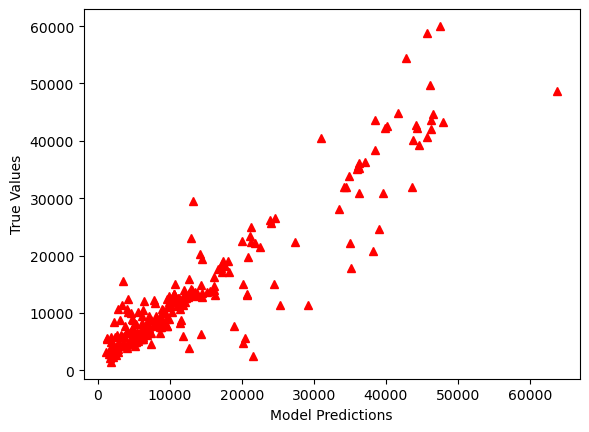

In [67]:
plt.plot(y_test_orig, y_predict_orig, "^", color = 'r')
plt.xlabel('Model Predictions')
plt.ylabel('True Values')

In [68]:
RMSE = float(format(np.sqrt(mean_squared_error(y_test_orig, y_predict_orig)),'.3f'))
MSE = mean_squared_error(y_test_orig, y_predict_orig)
MAE = mean_absolute_error(y_test_orig, y_predict_orig)

print(f"RMSE: {RMSE} | MSE: {MSE} | MAE: {MAE}")

RMSE: 4618.55 | MSE: 21331002.0 | MAE: 2792.28076171875
